In [2]:
import pandas as pd
import torch
from torch.nn import Linear
import torch.nn.functional as F
import numpy as np
import torch_geometric
from torch_geometric.data import Data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.nn.norm import LayerNorm
from pathlib import Path

In [3]:
folder_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\Data Sets for ML\Data Sets for ML"
folder = Path(folder_path)

In [4]:
df = pd.DataFrame()
for idx, p in enumerate(folder.glob("*/*/*/MergedGrainsData*")):
    df_tmp = pd.read_excel(p, header=1)
        
    percent = int(p.parts[-2][:-1])
    tmp = p.parts[-3].split("_")
    temperature = int(tmp[0])
    speed = tmp[1]
    speed = 0 if speed == "LS" else 1
    direction = int(p.parts[-4][1:])

    df_tmp["percent"] = percent
    df_tmp["temperature"] = temperature
    df_tmp["speed"] = speed
    df_tmp["direction"] = direction
    df_tmp["set_num"] = idx
    
    if idx == 0:
        df = df_tmp
    else:
        df = pd.concat([df, df_tmp], axis=0, ignore_index=True)

In [22]:
df.to_excel("grain_data.xlsx")

In [5]:
# csv_path = r"C:\Users\msi\Desktop\workspace\042_materials_GNN\00_data\data\MergedGrainsData.xlsx"
# df = pd.read_excel(csv_path, header=1)

# df.head()

In [5]:
df.columns

Index(['merged ID', 'original grain id', 'phi1', 'phi', 'phi2',
       'merged grain area', 'parent Area', 'daughter Area', 'other area',
       'no. of parent grains', 'no. of daughter grains',
       'daughter grains percent', 'other daughters', 'other daughters area',
       'major axis', 'aspect ratio', 'total boundary length',
       'border boundary length', 'internal boundary length', 'GOS', 'GAM',
       'Schmid SF1', 'Schmid SF2', 'Schmid SF3', 'Schmid SF4', 'Schmid SF5',
       'Schmid SF6', 'Taylor TF1', 'Taylor TF2', 'Taylor TF3', 'Taylor TF4',
       'Taylor TF5', 'Taylor TF6', 'Twin Count for Var1',
       'Twin Count for Var2', 'Twin Count for Var3', 'Twin Count for Var4',
       'Twin Count for Var5', 'Twin Count for Var6', 'Area Twinned for Var1',
       'Area Twinned for Var2', 'Area Twinned for Var3',
       'Area Twinned for Var4', 'Area Twinned for Var5',
       'Area Twinned for Var6', 'Schmid for Var1', 'Schmid for Var2',
       'Schmid for Var3', 'Schmid for Var

In [6]:
ID_COL = 'merged ID'
FEATURE_COLS = [
    'phi1',
    'phi',
    'phi2',
    'merged grain area',
    'major axis',
    'aspect ratio',
    'total boundary length',
    'GOS',
    'GAM',
    'Schmid SF1',
    'Schmid SF2',
    'Schmid SF3',
    'Schmid SF4',
    'Schmid SF5',
    'Schmid SF6',
    'Taylor TF1',
    'Taylor TF2',
    'Taylor TF3',
    'Taylor TF4',
    'Taylor TF5',
    'Taylor TF6',
    'Schmid for Var1',
    'Schmid for Var2',
    'Schmid for Var3',
    'Schmid for Var4',
    'Schmid for Var5',
    'Schmid for Var6',
    'percent',
    'temperature',
    'speed',
    'direction'
]
EDGE_COL = 'neighbor grain ids'

VAGUE_COLS = [
    'major axis',
    'aspect ratio',
    'merged grain area',
    'total boundary length'
]
FEATURE_COLS_INSIDE = [c for c in FEATURE_COLS if c not in VAGUE_COLS]

In [7]:
y = (df["daughter grains percent"] > 0).astype(int).to_numpy()

In [8]:
sum(y)

np.int64(2678)

In [9]:
df[FEATURE_COLS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19895 entries, 0 to 19894
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   phi1                   19895 non-null  float64
 1   phi                    19895 non-null  float64
 2   phi2                   19895 non-null  float64
 3   merged grain area      19895 non-null  int64  
 4   major axis             19895 non-null  float64
 5   aspect ratio           19895 non-null  float64
 6   total boundary length  19895 non-null  int64  
 7   GOS                    19895 non-null  float64
 8   GAM                    19895 non-null  float64
 9   Schmid SF1             19895 non-null  float64
 10  Schmid SF2             19895 non-null  float64
 11  Schmid SF3             19895 non-null  float64
 12  Schmid SF4             19895 non-null  float64
 13  Schmid SF5             19895 non-null  float64
 14  Schmid SF6             19895 non-null  float64
 15  Ta

In [10]:
df[FEATURE_COLS].describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,19895.000000,19895.000000,19895.000000,19895.00000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,...,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.00000,19895.000000,19895.000000
mean,29.120824,288.245686,28.832517,325.75049,21.244542,2.033940,87.887308,1.263270,0.866040,0.332478,...,0.178527,0.178735,0.169278,0.169258,0.120202,0.120015,4.841066,238.18673,0.630259,55.673787
std,26.438818,121.361371,28.352330,855.83364,19.706067,1.074106,106.378735,1.206655,0.514919,0.132308,...,0.261146,0.261554,0.271687,0.271737,0.261997,0.261373,1.993725,115.31642,0.482747,43.716888
min,0.001707,0.001946,0.023277,10.00000,3.685321,1.000000,14.000000,0.070525,0.129033,0.000084,...,-0.499920,-0.499964,-0.499985,-0.499807,-0.499997,-0.499496,3.000000,25.00000,0.000000,0.000000
25%,12.136830,314.666119,11.845387,35.00000,9.122364,1.421137,34.000000,0.460354,0.516037,0.238058,...,0.012569,0.011854,0.000826,0.000927,-0.068930,-0.067074,3.000000,175.00000,0.000000,0.000000
50%,25.605384,339.737126,24.505183,103.00000,15.581967,1.742125,58.000000,0.841719,0.745494,0.367902,...,0.247278,0.247817,0.243143,0.241900,0.147296,0.146205,3.000000,225.00000,1.000000,90.000000
75%,44.762547,351.808186,43.755890,287.00000,26.094585,2.266633,100.000000,1.625085,1.057264,0.444374,...,0.396695,0.396278,0.397310,0.396644,0.352671,0.353367,7.000000,325.00000,1.000000,90.000000
max,359.975532,359.998335,359.990164,29114.00000,246.901174,20.813044,2365.000000,13.286989,7.579747,0.499994,...,0.499829,0.499907,0.499923,0.499828,0.499997,0.499994,7.000000,425.00000,1.000000,90.000000


In [11]:
df[EDGE_COL]

0                                                  455,479
1                                              457,462,552
2                                                 8,11,459
3                                                  461,463
4                                                  458,481
                               ...                        
19890                                          532,545,547
19891                          696,698,705,724,728,746,922
19892                  679,682,686,707,711,720,723,763,808
19893    687,692,698,706,715,728,735,739,766,769,770,77...
19894                                                  896
Name: neighbor grain ids, Length: 19895, dtype: object

In [12]:
edges = []
edge_info = df[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info):
    for e in e_list:
        df_set = df[df["set_num"] == df.iloc[i]["set_num"]]
        node = df_set.index[df_set["merged ID"] == e].to_list()[0]
        
        new = [i, node]
        edges.append(new)
        
edge_index = torch.Tensor(edges).to(dtype=torch.long).t()

In [31]:
df.tail()

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
19890,919,538,39.399561,347.935385,17.936780,52,30,0,22,1,...,3,5,6,3,"532,545,547",7,425,1,90,27
19891,920,746,16.728591,0.639074,36.101943,309,233,76,0,1,...,4,2,1,7,"696,698,705,724,728,746,922",7,425,1,90,27
19892,921,754,41.199993,358.019199,15.227974,772,590,182,0,1,...,1,4,6,9,"679,682,686,707,711,720,723,763,808",7,425,1,90,27
19893,922,803,29.561427,1.504001,18.417803,1600,1068,0,532,1,...,1,5,6,18,"687,692,698,706,715,728,735,739,766,769,770,77...",7,425,1,90,27
19894,923,839,49.563917,336.054992,6.881720,35,21,14,0,1,...,5,6,3,1,896,7,425,1,90,27


In [32]:
np.random.seed(1105)

train_ratio = 0.8

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 15915
len(val_indices) = 1990
len(test_indices) = 1990
split done!


In [33]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [34]:
X_train = df.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (15915, 31) / (1990, 31) / (1990, 31)
y_train.shape = (15915,) / (1990,) / (1990,)


In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [36]:
X = np.zeros_like(df[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [37]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [38]:
data

Data(x=[19895, 31], edge_index=[2, 107484], y=[19895], train_mask=[19895], val_mask=[19895], test_mask=[19895])

In [39]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,...,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000,19895.000000
mean,-0.002250,-0.000063,0.002114,0.002729,0.003605,0.000826,0.001525,0.003949,0.001588,-0.003218,...,0.002789,0.002162,-0.001701,-0.002692,0.003786,0.005443,0.001909,-0.000805,0.001245,-0.002332
std,1.003738,0.999527,1.002992,0.995452,1.009343,0.992778,0.995571,1.001371,1.000073,1.002071,...,0.999717,0.999759,1.004813,1.004602,0.998704,0.998843,1.000179,0.996510,0.999690,1.000597
min,-1.107744,-2.374025,-1.017041,-0.364533,-0.895777,-0.954828,-0.689968,-0.985878,-1.429823,-2.520698,...,-2.594438,-2.592082,-2.476915,-2.476202,-2.360346,-2.362032,-0.921687,-1.843064,-1.303919,-1.276601
25%,-0.647040,0.217535,-0.598822,-0.335454,-0.617292,-0.565578,-0.502793,-0.662369,-0.678186,-0.718339,...,-0.632532,-0.635718,-0.624708,-0.625007,-0.717164,-0.709522,-0.921687,-0.546835,-1.303919,-1.276601
50%,-0.135712,0.424019,-0.150969,-0.256361,-0.286432,-0.268894,-0.278183,-0.345884,-0.232537,0.265074,...,0.265983,0.266222,0.271481,0.265862,0.107064,0.105531,-0.921687,-0.114759,0.766919,0.783330
75%,0.591582,0.523435,0.530043,-0.042344,0.252023,0.215900,0.114884,0.304210,0.372982,0.844258,...,0.837979,0.833695,0.841656,0.837945,0.889934,0.897203,1.084968,0.749394,0.766919,0.783330
max,12.558506,0.590889,11.717143,33.487426,11.561715,17.358032,21.312434,9.982114,13.040906,1.265505,...,1.232796,1.229805,1.221162,1.219414,1.451523,1.457544,1.084968,1.613546,0.766919,0.783330


In [40]:
# from torch_geometric.datasets import Planetoid
# from torch_geometric.transforms import NormalizeFeatures

# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

In [41]:
rf_model = RandomForestClassifier(
    n_estimators=5,
    max_depth=50,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


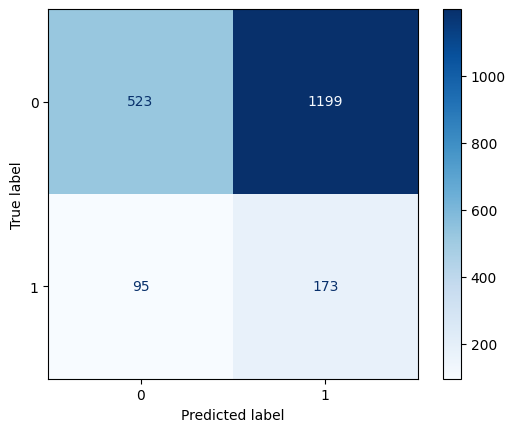

Accuracy: 0.3497
Precision: 0.1261
Recall: 0.6455
f1 score: 0.2110


In [42]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [43]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


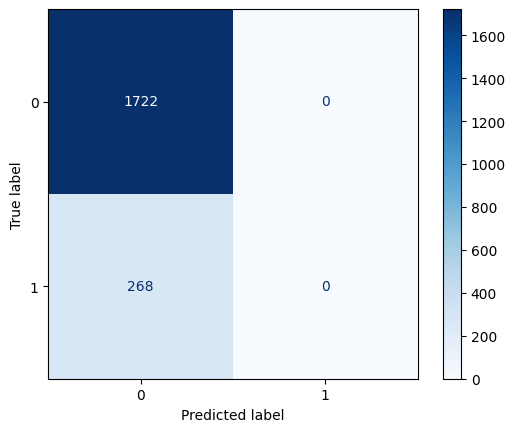

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [44]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [45]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 4.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


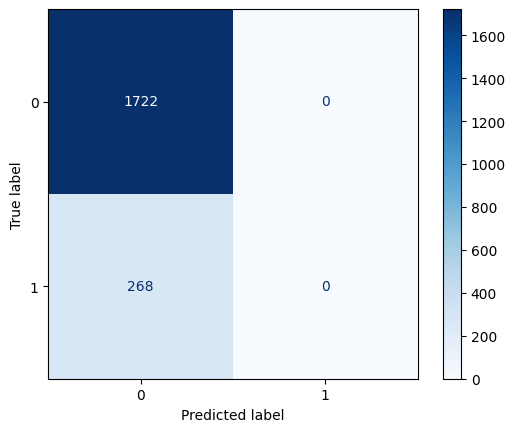

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [47]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [48]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [49]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8170 / Val_loss: 0.4073
Epoch: 002, Train_loss: 0.5628 / Val_loss: 0.4012
Epoch: 003, Train_loss: 0.4557 / Val_loss: 0.4168
Epoch: 004, Train_loss: 0.4212 / Val_loss: 0.4288
Epoch: 005, Train_loss: 0.4103 / Val_loss: 0.4361
Epoch: 006, Train_loss: 0.4131 / Val_loss: 0.4397
Epoch: 007, Train_loss: 0.4099 / Val_loss: 0.4406
Epoch: 008, Train_loss: 0.4146 / Val_loss: 0.4393
Epoch: 009, Train_loss: 0.4140 / Val_loss: 0.4362
Epoch: 010, Train_loss: 0.4163 / Val_loss: 0.4318
Epoch: 011, Train_loss: 0.4153 / Val_loss: 0.4265
Epoch: 012, Train_loss: 0.4135 / Val_loss: 0.4206
Epoch: 013, Train_loss: 0.4128 / Val_loss: 0.4147
Epoch: 014, Train_loss: 0.4098 / Val_loss: 0.4089
Epoch: 015, Train_loss: 0.4090 / Val_loss: 0.4037
Epoch: 016, Train_loss: 0.4060 / Val_loss: 0.3992
Epoch: 017, Train_loss: 0.4031 / Val_loss: 0.3958
Epoch: 018, Train_loss: 0.4011 / Val_loss: 0.3934
Epoch: 019, Train_loss: 0.3999 / Val_loss: 0.3919
Epoch: 020, Train_loss: 0.4019 / Val_loss: 0.3911


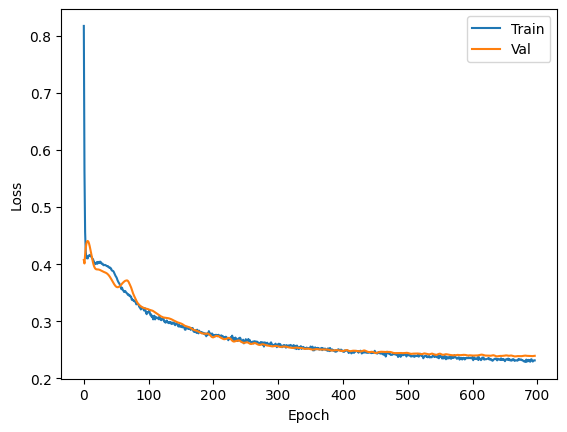

In [50]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

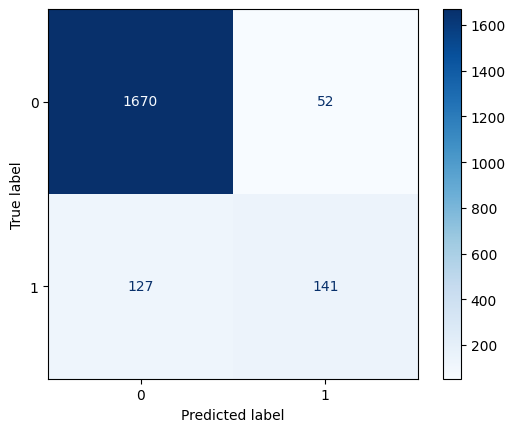

Accuracy: 0.9101
Precision: 0.7306
Recall: 0.5261
f1 score: 0.6117


In [51]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [52]:
import shap

shap.initjs()

shap_data = data.x[data.train_mask]
background = shap_data[np.random.choice(shap_data.shape[0], 2000, replace=False)]
shap_test = data.x[data.test_mask][np.random.choice(data.x[data.test_mask].shape[0], 200, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(shap_test, check_additivity=False)

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:243: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f'unrecognized nn.Module: {module_type}')


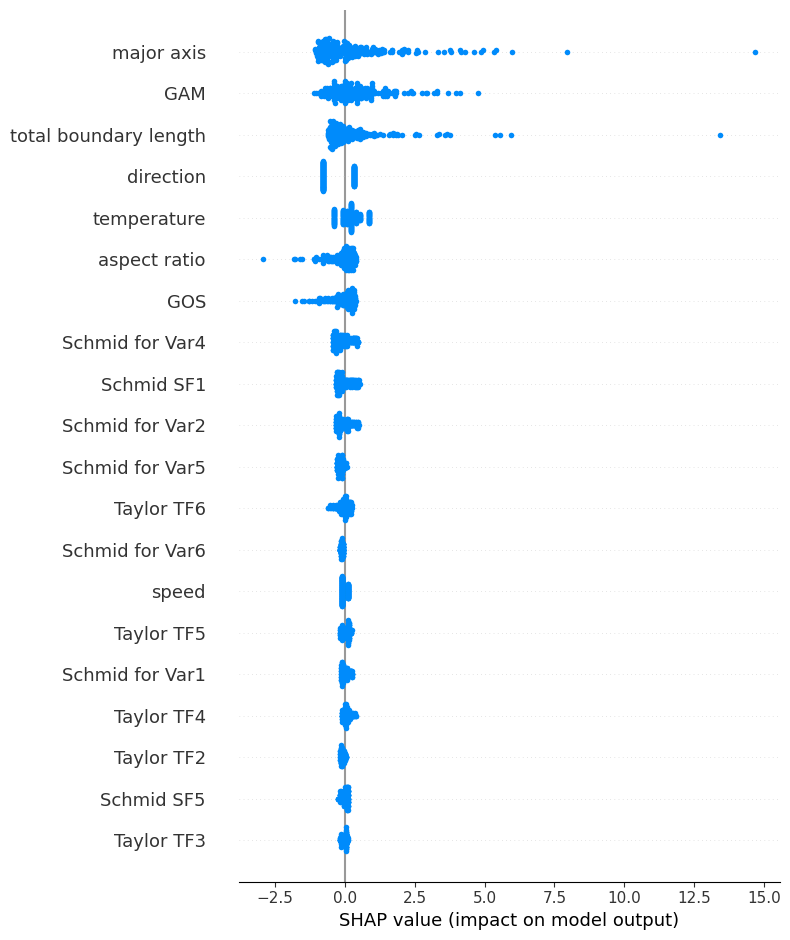

In [53]:
# exp = shap.Explanation(shap_values.squeeze(), feature_names=FEATURE_COLS)
# shap.plots.beeswarm(exp, color=['red', 'blue'])

shap.summary_plot(shap_values.squeeze(), feature_names=FEATURE_COLS)

In [55]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [56]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5200 / Val_loss: 0.5193
Epoch: 002, Train_loss: 0.4676 / Val_loss: 0.4685
Epoch: 003, Train_loss: 0.4331 / Val_loss: 0.4253
Epoch: 004, Train_loss: 0.4343 / Val_loss: 0.4308
Epoch: 005, Train_loss: 0.4220 / Val_loss: 0.4192
Epoch: 006, Train_loss: 0.4212 / Val_loss: 0.4272
Epoch: 007, Train_loss: 0.4170 / Val_loss: 0.4196
Epoch: 008, Train_loss: 0.4118 / Val_loss: 0.4094
Epoch: 009, Train_loss: 0.4101 / Val_loss: 0.4069
Epoch: 010, Train_loss: 0.4109 / Val_loss: 0.4072
Epoch: 011, Train_loss: 0.4084 / Val_loss: 0.4057
Epoch: 012, Train_loss: 0.4072 / Val_loss: 0.4008
Epoch: 013, Train_loss: 0.4035 / Val_loss: 0.4077
Epoch: 014, Train_loss: 0.4029 / Val_loss: 0.4046
Epoch: 015, Train_loss: 0.4018 / Val_loss: 0.3998
Epoch: 016, Train_loss: 0.4018 / Val_loss: 0.3981
Epoch: 017, Train_loss: 0.3970 / Val_loss: 0.4061
Epoch: 018, Train_loss: 0.3980 / Val_loss: 0.3996
Epoch: 019, Train_loss: 0.3966 / Val_loss: 0.4007
Epoch: 020, Train_loss: 0.3955 / Val_loss: 0.3982


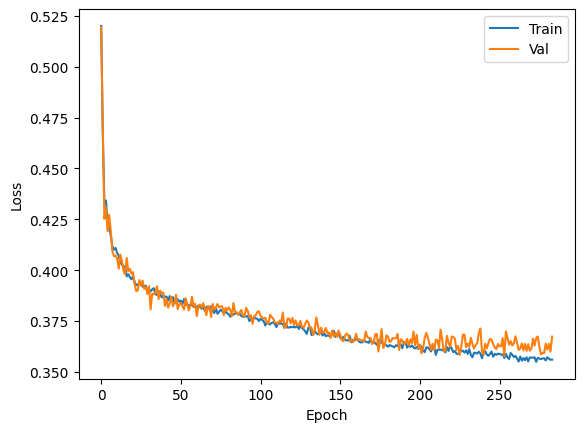

In [57]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [58]:
model.eval()
out = model(data.x, data.edge_index)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
with torch.no_grad():
    pred = F.sigmoid(out).round()

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

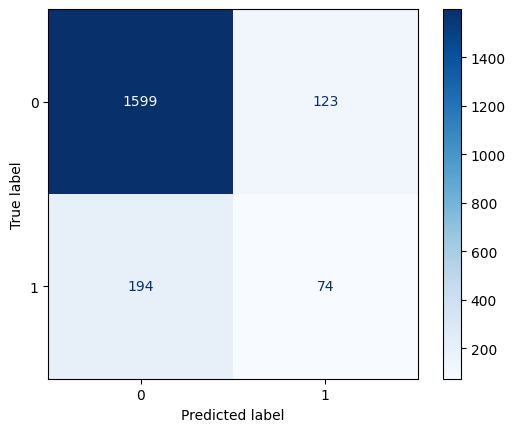

Accuracy: 0.8407
Precision: 0.3756
Recall: 0.2761
f1 score: 0.3183


In [59]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [60]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [61]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5611 / Val_loss: 0.5498
Epoch: 002, Train_loss: 0.4793 / Val_loss: 0.4816
Epoch: 003, Train_loss: 0.4710 / Val_loss: 0.4731
Epoch: 004, Train_loss: 0.4419 / Val_loss: 0.4385
Epoch: 005, Train_loss: 0.4242 / Val_loss: 0.4254
Epoch: 006, Train_loss: 0.3979 / Val_loss: 0.3921
Epoch: 007, Train_loss: 0.3968 / Val_loss: 0.3877
Epoch: 008, Train_loss: 0.3974 / Val_loss: 0.4014
Epoch: 009, Train_loss: 0.3886 / Val_loss: 0.3916
Epoch: 010, Train_loss: 0.4017 / Val_loss: 0.3977
Epoch: 011, Train_loss: 0.3907 / Val_loss: 0.4057
Epoch: 012, Train_loss: 0.3812 / Val_loss: 0.3810
Epoch: 013, Train_loss: 0.3762 / Val_loss: 0.3713
Epoch: 014, Train_loss: 0.3783 / Val_loss: 0.3729
Epoch: 015, Train_loss: 0.3775 / Val_loss: 0.3770
Epoch: 016, Train_loss: 0.3750 / Val_loss: 0.3712
Epoch: 017, Train_loss: 0.3722 / Val_loss: 0.3741
Epoch: 018, Train_loss: 0.3715 / Val_loss: 0.3721
Epoch: 019, Train_loss: 0.3703 / Val_loss: 0.3691
Epoch: 020, Train_loss: 0.3693 / Val_loss: 0.3716


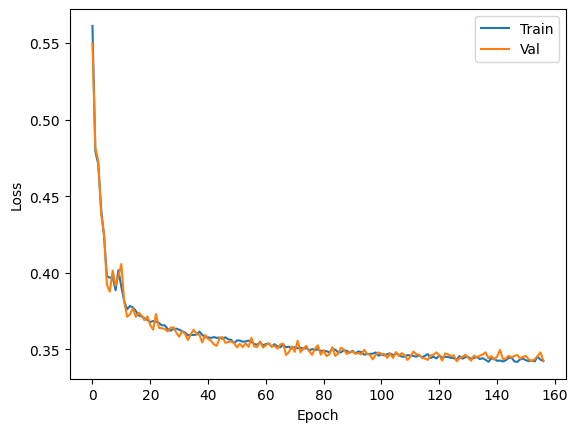

In [62]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [63]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

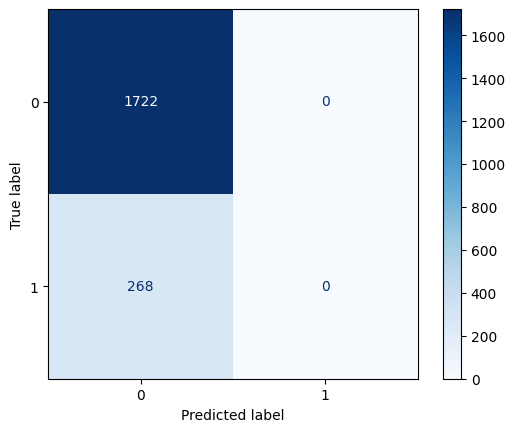

Accuracy: 0.8653
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

#### 외곽선에 걸친 샘플 제거

In [13]:
BORDER_COL = 'border boundary length'
df_inside = df[df[BORDER_COL] == 0]
df_inside = df_inside.reset_index(drop=True)

In [14]:
df_inside.shape

(17123, 64)

In [15]:
edges_2 = []
edge_info_2 = df_inside[EDGE_COL].map(lambda x: list(map(int, x.split(","))))
for i, e_list in enumerate(edge_info_2):
    df_set = df_inside[df_inside["set_num"] == df_inside.iloc[i]["set_num"]]
    indices_included = df_set["merged ID"].tolist()
    for e in e_list:
        if e in indices_included:
            idx = df_set.index[df_set["merged ID"] == e].tolist()[0]
            new = [i, idx]
            edges_2.append(new)
        
edge_index_2 = torch.Tensor(edges_2).to(dtype=torch.long).t()

In [16]:
edge_index_2[:, edge_index_2[0] == 15234]

tensor([[15234, 15234, 15234, 15234],
        [15214, 15226, 15262, 15567]])

In [17]:
edge_index_2[0, 74160]

tensor(15209)

In [18]:
df_inside[df_inside["set_num"] == df_inside["set_num"].iloc[-1]][:50]

,merged ID,original grain id,phi1,phi,phi2,merged grain area,parent Area,daughter Area,other area,no. of parent grains,...,Rank for Var4,Rank for Var5,Rank for Var6,neighbor grains count,neighbor grain ids,percent,temperature,speed,direction,set_num
16313,9,9,10.134939,7.609234,51.019148,26,26,0,0,1,...,4,3,6,3,"2,46,59",7,425,1,90,27
16314,10,10,52.390215,355.674708,2.241037,31,31,0,0,1,...,1,4,6,4,"1,4,12,44",7,425,1,90,27
16315,11,11,8.105772,8.579832,53.733370,20,20,0,0,1,...,2,6,5,3,"2,14,59",7,425,1,90,27
16316,13,13,15.607356,323.174189,40.657522,21,21,0,0,1,...,4,6,5,5,"8,12,20,22,36",7,425,1,90,27
16317,17,17,54.604796,354.143851,9.170345,21,21,0,0,1,...,1,4,6,3,"16,28,42",7,425,1,90,27
16318,18,18,24.977943,311.062411,16.112529,15,15,0,0,1,...,6,3,4,1,89,7,425,1,90,27
16319,22,22,30.436445,355.589853,36.563338,66,66,0,0,1,...,6,2,1,5,"13,20,27,36,66",7,425,1,90,27
16320,23,23,15.222485,341.649022,51.687015,72,72,0,0,1,...,2,6,5,4,"16,25,28,56",7,425,1,90,27
16321,24,24,46.440236,356.917186,6.967073,12,12,0,0,1,...,1,5,6,2,"32,44",7,425,1,90,27
16322,25,25,14.047018,314.795996,32.222028,293,293,0,0,1,...,4,6,5,6,"6,16,23,56,80,89",7,425,1,90,27


In [19]:
d = pd.DataFrame(edge_index_2.t())

In [20]:
sum(d.apply(lambda x: set(x), axis=1).value_counts() != 2)

0

In [21]:
y = (df_inside["daughter grains percent"] > 0).map(int).to_numpy()

In [22]:
np.random.seed(1105)

train_ratio = 0.7

pos_indices = np.where(y == 1)[0]
pos_indices_train, pos_indices_others = train_test_split(
    pos_indices,
    train_size=train_ratio
)
pos_indices_val, pos_indices_test = train_test_split(
    pos_indices_others,
    train_size=0.5
)
assert len(pos_indices) == len(pos_indices_train) + len(pos_indices_val) + len(pos_indices_test)
assert set(pos_indices.tolist()) == set(pos_indices_train.tolist()) | set(pos_indices_val.tolist()) | set(pos_indices_test.tolist())
assert len(set(pos_indices_train.tolist()).intersection(set(pos_indices_val.tolist())).intersection(set(pos_indices_test.tolist()))) == 0

neg_indices = np.where(y == 0)[0]
neg_indices_train, neg_indices_others = train_test_split(
    neg_indices,
    train_size=train_ratio
)
neg_indices_val, neg_indices_test = train_test_split(
    neg_indices_others,
    train_size=0.5
)
assert len(neg_indices) == len(neg_indices_train) + len(neg_indices_val) + len(neg_indices_test)
assert set(neg_indices.tolist()) == set(neg_indices_train.tolist()) | set(neg_indices_val.tolist()) | set(neg_indices_test.tolist())
assert len(set(neg_indices_train.tolist()).intersection(set(neg_indices_val.tolist())).intersection(set(neg_indices_test.tolist()))) == 0

train_indices = pos_indices_train.tolist() + neg_indices_train.tolist()
val_indices = pos_indices_val.tolist() + neg_indices_val.tolist()
test_indices = pos_indices_test.tolist() + neg_indices_test.tolist()

print(f"{len(train_indices) = }")
print(f"{len(val_indices) = }")
print(f"{len(test_indices) = }")

print("split done!")

len(train_indices) = 11985
len(val_indices) = 2568
len(test_indices) = 2570
split done!


In [23]:
tmp_train_mask = np.zeros_like(y)
for i in train_indices:
    tmp_train_mask[i] = 1
train_mask = torch.Tensor(tmp_train_mask).to(dtype=bool)

tmp_val_mask = np.zeros_like(y)
for i in val_indices:
    tmp_val_mask[i] = 1
val_mask = torch.Tensor(tmp_val_mask).to(dtype=bool)

tmp_test_mask = np.zeros_like(y)
for i in test_indices:
    tmp_test_mask[i] = 1
test_mask = torch.Tensor(tmp_test_mask).to(dtype=bool)

assert (train_mask.to(dtype=torch.int16) + val_mask.to(dtype=torch.int16) + test_mask.to(dtype=torch.int16) == 1).all()

In [24]:
X_train = df_inside.loc[train_mask.numpy(), FEATURE_COLS]
X_val = df_inside.loc[val_mask.numpy(), FEATURE_COLS]
X_test = df_inside.loc[test_mask.numpy(), FEATURE_COLS]
y_train = y[train_mask.numpy()]
y_val = y[val_mask.numpy()]
y_test = y[test_mask.numpy()]

print(f"{X_train.shape = } / {X_val.shape} / {X_test.shape}")
print(f"{y_train.shape = } / {y_val.shape} / {y_test.shape}")

X_train.shape = (11985, 31) / (2568, 31) / (2570, 31)
y_train.shape = (11985,) / (2568,) / (2570,)


In [25]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [26]:
X = np.zeros_like(df_inside[FEATURE_COLS])
X[train_mask.numpy(), :] = X_train_norm
X[val_mask.numpy(), :] = X_val_norm
X[test_mask.numpy(), :] = X_test_norm

In [27]:
data = Data(
    x=torch.Tensor(X),
    y=torch.Tensor(y),
    edge_index=edge_index_2,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask,
)

In [28]:
data

Data(x=[17123, 31], edge_index=[2, 83670], y=[17123], train_mask=[17123], val_mask=[17123], test_mask=[17123])

In [29]:
pd.DataFrame(X, columns=FEATURE_COLS).describe()

,phi1,phi,phi2,merged grain area,major axis,aspect ratio,total boundary length,GOS,GAM,Schmid SF1,...,Schmid for Var1,Schmid for Var2,Schmid for Var3,Schmid for Var4,Schmid for Var5,Schmid for Var6,percent,temperature,speed,direction
count,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,...,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000,17123.000000
mean,0.000547,-0.002344,0.003077,-0.006279,-0.001873,-0.002472,-0.003490,-0.002157,-0.002192,-0.006115,...,-0.001954,-0.001583,0.000012,0.000591,0.002487,0.001531,-0.000135,-0.006233,-0.007106,-0.005172
std,0.991357,1.001715,1.030565,0.941017,0.980058,0.987452,0.966357,0.996859,0.986062,1.002501,...,1.004212,1.003941,1.001526,1.002483,1.000459,0.999539,1.000018,1.002780,1.001933,1.001365
min,-1.129280,-2.377651,-1.078449,-0.366503,-0.909469,-0.939844,-0.715928,-0.992681,-1.395130,-2.546045,...,-2.623393,-2.618560,-2.489490,-2.488836,-2.367794,-2.372208,-0.923563,-1.858356,-1.308023,-1.294535
25%,-0.652168,0.217240,-0.632058,-0.336223,-0.623517,-0.548607,-0.508435,-0.661786,-0.674270,-0.714431,...,-0.636560,-0.638462,-0.619912,-0.620269,-0.718746,-0.710388,-0.923563,-0.555419,-1.308023,-1.294535
50%,-0.130837,0.423486,-0.155363,-0.251964,-0.282125,-0.258468,-0.269818,-0.344713,-0.242790,0.268460,...,0.262533,0.262979,0.270901,0.268230,0.107480,0.102993,-0.923563,-0.121107,0.764512,0.772478
75%,0.614614,0.521720,0.575267,-0.024204,0.271302,0.208509,0.145168,0.283190,0.367311,0.835588,...,0.833937,0.832144,0.837074,0.835035,0.887048,0.890584,1.082763,0.747517,0.764512,0.772478
max,12.899857,0.589558,12.501791,37.949964,11.973679,17.917576,16.557858,10.353765,12.481496,1.254003,...,1.240289,1.237809,1.224330,1.225363,1.458818,1.461393,1.082763,1.616141,0.764512,0.772478


In [30]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=100,
    random_state=1105
)

rf_model.fit(X_train_norm, y[train_mask])
y_pred = rf_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


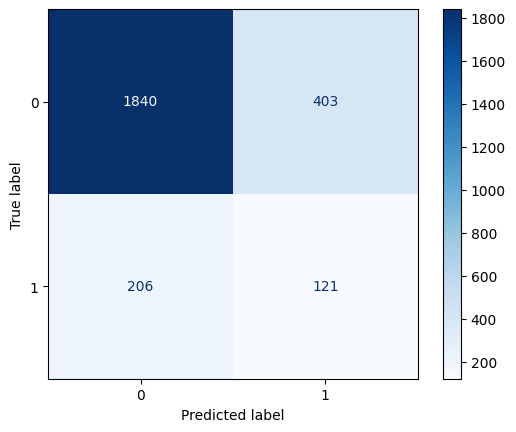

Accuracy: 0.7630
Precision: 0.2309
Recall: 0.3700
f1 score: 0.2844


In [31]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [32]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    random_state=1105
)

lr_model.fit(X_train_norm, y[train_mask])
y_pred = lr_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


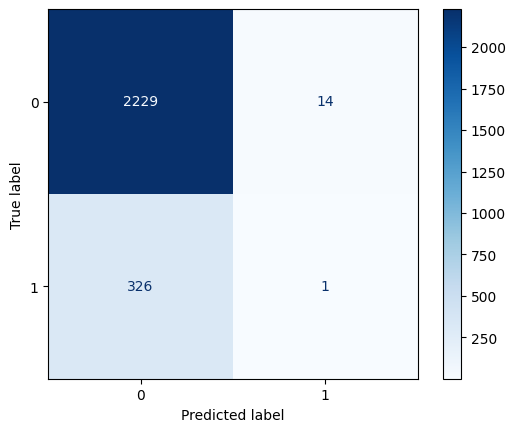

Accuracy: 0.8677
Precision: 0.0667
Recall: 0.0031
f1 score: 0.0058


In [33]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [34]:
from sklearn.svm import LinearSVC

class_weight = {
    0: 1.0,
    1: 5.0
}
svc_model = LinearSVC(
    class_weight=class_weight,
    random_state=1105
)

svc_model.fit(X_train_norm, y[train_mask])
y_pred = svc_model.predict(X_test)
y_true = y[test_mask]

c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


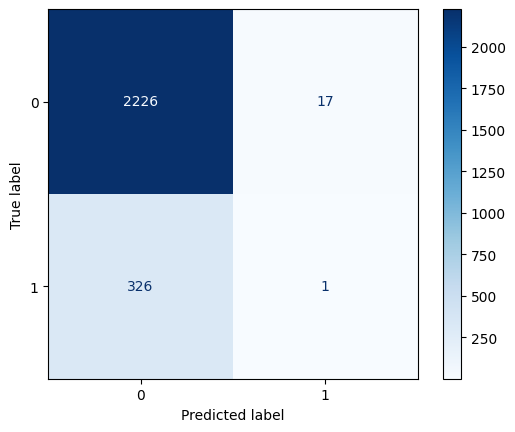

Accuracy: 0.8665
Precision: 0.0556
Recall: 0.0031
f1 score: 0.0058


In [35]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [36]:
def count_parameters(params):
    num = sum(p.numel() for p in params if p.requires_grad)
    print(f"{num:,}")
    return num

In [37]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(data.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels * 2)
        self.lin3 = Linear(hidden_channels * 2, hidden_channels * 4)
        self.lin4 = Linear(hidden_channels * 4, hidden_channels * 8)
        self.lin5 = Linear(hidden_channels * 8, hidden_channels * 4)
        self.lin6 = Linear(hidden_channels * 4, hidden_channels * 2)
        self.lin7 = Linear(hidden_channels * 2, 1)
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels * 2)
        self.norm3 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm4 = torch.nn.LayerNorm(hidden_channels * 8)
        self.norm5 = torch.nn.LayerNorm(hidden_channels * 4)
        self.norm6 = torch.nn.LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin7(x)
        # x = self.log_softmax(x)
        # x = x.squeeze()
        return x
    
model = MLP(hidden_channels=64)
print(f"MLP model number of params: {count_parameters(model.parameters()):,}")

342,017
MLP model number of params: 342,017


In [38]:
weight = torch.Tensor([1.0, 2.5])
criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    X_tmp = data.x[data.train_mask]
    y_tmp = data.y[data.train_mask]
    preds = model(X_tmp).squeeze()  # Perform a single forward pass.
    loss = criterion(preds, y_tmp)  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_X_tmp = data.x[data.val_mask]
        v_y_tmp = data.y[data.val_mask]
        v_preds = model(v_X_tmp).squeeze()
        v_loss = criterion(v_preds, v_y_tmp)
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.8189 / Val_loss: 0.3965
Epoch: 002, Train_loss: 0.5596 / Val_loss: 0.3835
Epoch: 003, Train_loss: 0.4498 / Val_loss: 0.3972
Epoch: 004, Train_loss: 0.4092 / Val_loss: 0.4083
Epoch: 005, Train_loss: 0.3966 / Val_loss: 0.4155
Epoch: 006, Train_loss: 0.3982 / Val_loss: 0.4196
Epoch: 007, Train_loss: 0.3948 / Val_loss: 0.4213
Epoch: 008, Train_loss: 0.3984 / Val_loss: 0.4212
Epoch: 009, Train_loss: 0.4002 / Val_loss: 0.4195
Epoch: 010, Train_loss: 0.4018 / Val_loss: 0.4165
Epoch: 011, Train_loss: 0.3987 / Val_loss: 0.4126
Epoch: 012, Train_loss: 0.3983 / Val_loss: 0.4079
Epoch: 013, Train_loss: 0.4008 / Val_loss: 0.4029
Epoch: 014, Train_loss: 0.3975 / Val_loss: 0.3977
Epoch: 015, Train_loss: 0.3980 / Val_loss: 0.3927
Epoch: 016, Train_loss: 0.3930 / Val_loss: 0.3881
Epoch: 017, Train_loss: 0.3908 / Val_loss: 0.3843
Epoch: 018, Train_loss: 0.3889 / Val_loss: 0.3812
Epoch: 019, Train_loss: 0.3891 / Val_loss: 0.3791
Epoch: 020, Train_loss: 0.3886 / Val_loss: 0.3777


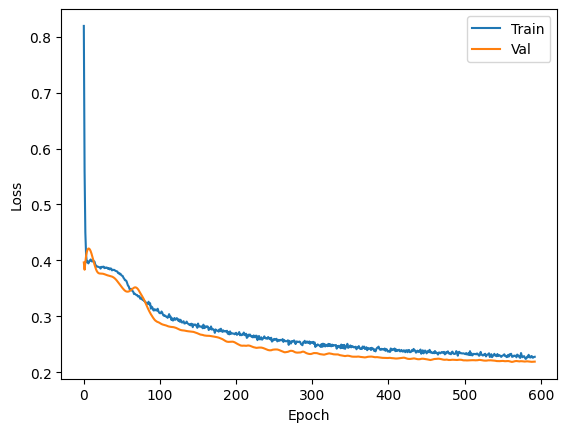

In [39]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

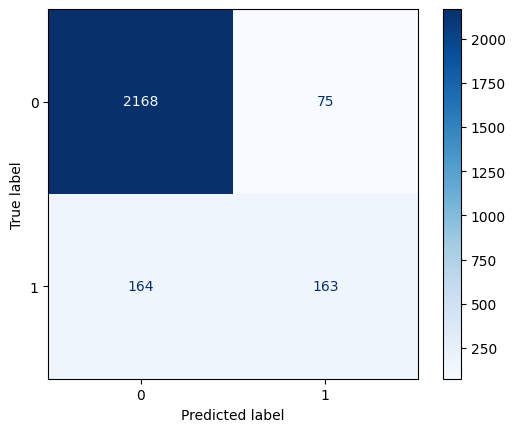

Accuracy: 0.9070
Precision: 0.6849
Recall: 0.4985
f1 score: 0.5770


In [40]:
model.eval()
X_tmp_test = data.x[data.test_mask]
y_tmp_test = data.y[data.test_mask]
with torch.no_grad():
    out = model(X_tmp_test)
# pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = F.sigmoid(out).round()

cm = confusion_matrix(y_tmp_test, pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Precision: {precision_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"Recall: {recall_score(y_tmp_test.numpy(), pred.numpy()):.4f}")
print(f"f1 score: {f1_score(y_tmp_test.numpy(), pred.numpy()):.4f}")

In [41]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GCNConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GCNConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        x = x.squeeze()
        # x = self.log_softmax(x)
        return x

model = GCN(hidden_channels=64)
print(f"GCN model number of params: {count_parameters(model.parameters()):,}")

342,017
GCN model number of params: 342,017


In [42]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight)  # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5027 / Val_loss: 0.4937
Epoch: 002, Train_loss: 0.4618 / Val_loss: 0.4681
Epoch: 003, Train_loss: 0.4216 / Val_loss: 0.4171
Epoch: 004, Train_loss: 0.4076 / Val_loss: 0.4087
Epoch: 005, Train_loss: 0.4136 / Val_loss: 0.4129
Epoch: 006, Train_loss: 0.3974 / Val_loss: 0.4006
Epoch: 007, Train_loss: 0.3984 / Val_loss: 0.3924
Epoch: 008, Train_loss: 0.3988 / Val_loss: 0.3972
Epoch: 009, Train_loss: 0.3982 / Val_loss: 0.3897
Epoch: 010, Train_loss: 0.3939 / Val_loss: 0.3866
Epoch: 011, Train_loss: 0.3903 / Val_loss: 0.3862
Epoch: 012, Train_loss: 0.3882 / Val_loss: 0.3900
Epoch: 013, Train_loss: 0.3919 / Val_loss: 0.3884
Epoch: 014, Train_loss: 0.3858 / Val_loss: 0.3908
Epoch: 015, Train_loss: 0.3801 / Val_loss: 0.3829
Epoch: 016, Train_loss: 0.3808 / Val_loss: 0.3925
Epoch: 017, Train_loss: 0.3847 / Val_loss: 0.3837
Epoch: 018, Train_loss: 0.3846 / Val_loss: 0.3792
Epoch: 019, Train_loss: 0.3821 / Val_loss: 0.3933
Epoch: 020, Train_loss: 0.3774 / Val_loss: 0.3810


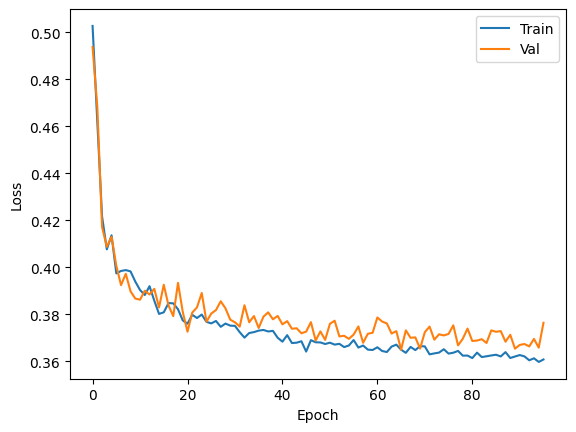

In [43]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

In [44]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

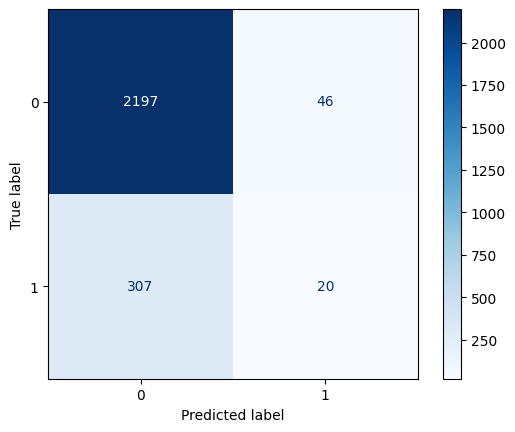

Accuracy: 0.8626
Precision: 0.3030
Recall: 0.0612
f1 score: 0.1018


In [45]:
cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [46]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels * 2)
        self.conv3 = GATConv(hidden_channels * 2, hidden_channels * 4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels * 8)
        self.conv5 = GATConv(hidden_channels * 8, hidden_channels * 4)
        self.conv6 = GATConv(hidden_channels * 4, hidden_channels * 2)
        self.conv7 = GATConv(hidden_channels * 2, 1)
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels * 2)
        self.norm3 = LayerNorm(hidden_channels * 4)
        self.norm4 = LayerNorm(hidden_channels * 8)
        self.norm5 = LayerNorm(hidden_channels * 4)
        self.norm6 = LayerNorm(hidden_channels * 2)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv7(x, edge_index)
        # x = self.log_softmax(x)
        x = x.squeeze()
        return x


model = GAT(hidden_channels=64)
print(f"GAT model number of params: {count_parameters(model.parameters()):,}")

344,707
GAT model number of params: 344,707


In [47]:
weight = torch.Tensor([1.0, 2.5])
# criterion = torch.nn.NLLLoss(weight=weight) # Define loss criterion.
criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Define optimizer.

losses = []
v_losses = []
best_v_loss = 100000
COUNT = 30
val_early_stop_count = COUNT
val_early_stop_continuous_flag = False

for epoch in range(1, 2001):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    outs = model(data.x, data.edge_index)  # Perform a single forward pass.
    preds = outs[data.train_mask]
    loss = criterion(preds, data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    losses.append(loss.item())
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    
    model.eval()
    with torch.no_grad():
        v_preds = outs[data.val_mask]
        v_loss = criterion(v_preds, data.y[data.val_mask])
        v_losses.append(v_loss.item())
    print(f'Epoch: {epoch:03d}, Train_loss: {loss:.4f} / Val_loss: {v_loss:.4f}')
    
    if v_loss.item() < best_v_loss:
        best_v_loss = v_loss.item()
        val_early_stop_continuous_flag = False
        val_early_stop_count = COUNT
    else:
        val_early_stop_continuous_flag = True
        val_early_stop_count -= 1
        if val_early_stop_count == 0:
            print(f"============== Early stopped at Epoch: {epoch}")
            break

Epoch: 001, Train_loss: 0.5874 / Val_loss: 0.5785
Epoch: 002, Train_loss: 0.4488 / Val_loss: 0.4442
Epoch: 003, Train_loss: 0.4530 / Val_loss: 0.4505
Epoch: 004, Train_loss: 0.4436 / Val_loss: 0.4345
Epoch: 005, Train_loss: 0.4208 / Val_loss: 0.4124
Epoch: 006, Train_loss: 0.3966 / Val_loss: 0.3984
Epoch: 007, Train_loss: 0.3798 / Val_loss: 0.3777
Epoch: 008, Train_loss: 0.3737 / Val_loss: 0.3718
Epoch: 009, Train_loss: 0.3742 / Val_loss: 0.3683
Epoch: 010, Train_loss: 0.3687 / Val_loss: 0.3687
Epoch: 011, Train_loss: 0.3729 / Val_loss: 0.3762
Epoch: 012, Train_loss: 0.3717 / Val_loss: 0.3744
Epoch: 013, Train_loss: 0.3662 / Val_loss: 0.3625
Epoch: 014, Train_loss: 0.3618 / Val_loss: 0.3600
Epoch: 015, Train_loss: 0.3622 / Val_loss: 0.3557
Epoch: 016, Train_loss: 0.3566 / Val_loss: 0.3575
Epoch: 017, Train_loss: 0.3582 / Val_loss: 0.3538
Epoch: 018, Train_loss: 0.3577 / Val_loss: 0.3548
Epoch: 019, Train_loss: 0.3577 / Val_loss: 0.3528
Epoch: 020, Train_loss: 0.3592 / Val_loss: 0.3543


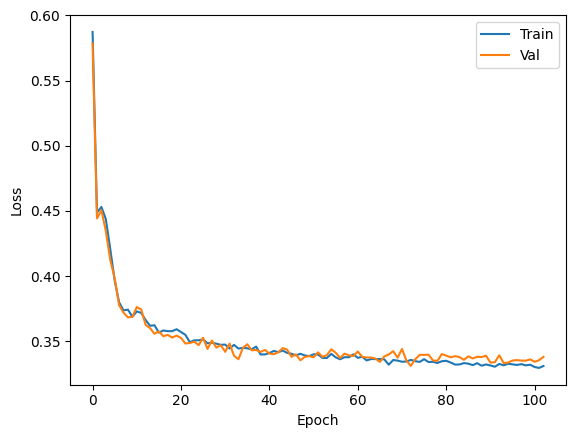

In [48]:
plt.plot(losses)
plt.plot(v_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"])
plt.show()

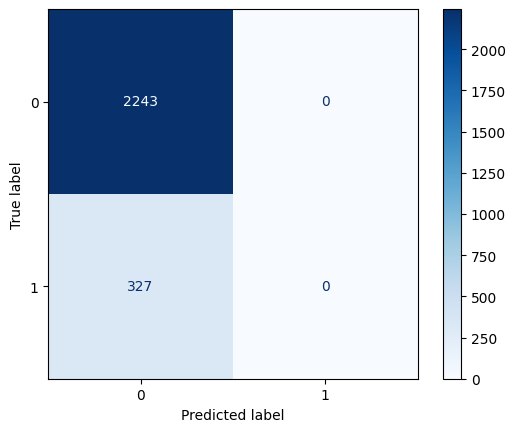

Accuracy: 0.8728
Precision: 0.0000
Recall: 0.0000
f1 score: 0.0000


c:\Users\msi\Desktop\workspace\042_materials_GNN\01_src\gnn_node_classification\.venv_gnn\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
pred = F.sigmoid(out).round()
# pred = out.argmax(dim=1)  # Use the class with highest probability.

y_pred = pred[data.test_mask].numpy()
y_true = data.y[data.test_mask].numpy()

cm = confusion_matrix(y_true, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
)

disp.plot(cmap="Blues")
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"f1 score: {f1_score(y_true, y_pred):.4f}")

In [50]:
sum(y) / len(y)

np.float64(0.12702213397185072)